In [ ]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
path = '/content/drive/MyDrive/Supreme Project/dataset'

In [ ]:
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf='https://zissou.infosci.cornell.edu/convokit/datasets/supreme-corpus/cases.jsonl', lines=True)
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [ ]:
# combine text from all utterances in a conversation back into one string based on the conversation_id, coount how many utterances per conversation
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
utt_per_conv['num_utterances'] = df_utts.groupby('conversation_id')['text'].count().reset_index()['text']

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_utt = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

In [ ]:
# combine text from all conversation in a cases into one string based on the meta.case_id
conv_per_case = df_convos_utt.groupby('meta.case_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
conv_per_case['num_conversations'] = df_convos_utt.groupby('meta.case_id')['text'].count().reset_index()['text']
conv_per_case['num_utterances'] = df_convos_utt.groupby('meta.case_id')['num_utterances'].sum().reset_index()['num_utterances']

# add the combined text case dataframe, merge on meta.case_id and id
df_cases_convo = df_cases.merge(conv_per_case, left_on='id', right_on='meta.case_id', how='left')
df_cases_convo.head(3)

,id,year,citation,title,petitioner,respondent,docket_no,court,decided_date,url,...,win_side_detail,scdb_docket_id,votes,votes_detail,is_eq_divided,votes_side,meta.case_id,text,num_conversations,num_utterances
0,2011_11-1179,2011,567 US _,"American Tradition Partnership, Inc. v. Bullock","American Tradition Partnership, Inc.","Steve Bullock, Attorney General of Montana, et...",11-1179,Roberts Court,"Jun 25, 2012",https://www.oyez.org/cases/2011/11-1179,...,3.0,2011-073-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",NaN,NaN,NaN,NaN
1,2011_11-182,2011,567 US _,Arizona v. United States,Arizona et al.,United States,11-182,Roberts Court,"Jun 25, 2012",https://www.oyez.org/cases/2011/11-182,...,7.0,2011-075-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 0.0, 'j__antonin_scal...",2011_11-182,We'll hear argument this morning in Case 11-18...,1.0,295.0
2,2011_11-161,2011,566 US _,Armour v. City of Indianapolis,Christine Armour,City of Indianapolis,11-161,Roberts Court,"Jun 4, 2012",https://www.oyez.org/cases/2011/11-161,...,2.0,2011-062-01,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",2011_11-161,We will hear argument this morning in case 11-...,1.0,239.0


In [ ]:
df_cases_convo.dropna(subset=['text'], inplace=True)

In [ ]:
# transform to pd.to_datetime
df_cases_convo.decided_date = pd.to_datetime(df_cases_convo.decided_date)

In [ ]:
df_cases_convo.to_csv('df_cases_convo.csv', index=False)

In [ ]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove words with length less than 3
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    stemmer = PorterStemmer() # Stem the words
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [ ]:
df = df_cases_convo.copy()

In [ ]:
text = df_cases_convo.loc[:,['text','win_side']]

In [ ]:
text.to_csv('text.csv', index=False)

In [ ]:
# preprocess text
df.loc[:, 'text_pre'] = df['text'].apply(preprocess_text)
text.to_csv('text_clean.csv', index=False)

In [ ]:
text = pd.read_csv('text_clean.csv')

In [ ]:
text.head()

,text,win_side
0,We'll hear argument this morning in Case 11-18...,0.0
1,We will hear argument this morning in case 11-...,0.0
2,We will hear argument first this morning in Ca...,1.0
3,"We'll hear argument next in Case 10-1320, Blue...",0.0
4,We'll hear argument first this morning in Case...,1.0


In [ ]:
text.loc[:, 'text'] = text['text'].apply(preprocess_text)

In [ ]:
text.head()

,text,win_side
0,hear argument morn case arizona unit state cle...,0.0
1,hear argument morn case armour citi indianapol...,0.0
2,hear argument first morn case astru capato mil...,1.0
3,hear argument next case blueford arkansa sloan...,0.0
4,hear argument first morn case caraco pharmaceu...,1.0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
def knn_classification_plot(dataset, text_column, label_column, method='bow', k_range=range(1, 10)):
  X = dataset[text_column]
  y = dataset[label_column]
  if method == 'bow':
    vectorizer = CountVectorizer()
  elif method == 'tfidf':
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)
  X = vectorizer.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  accuracies = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
  
  best_k = k_range[accuracies.index(max(accuracies))]
  print(f"Best value of k: {best_k} with accuracy: {max(accuracies)}")
    
  plt.plot(k_range, accuracies)
  plt.xlabel('k')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
dataset = text
text_column = 'text'
label_column = 'win_side'

Best value of k: 7 with accuracy: 0.6857142857142857


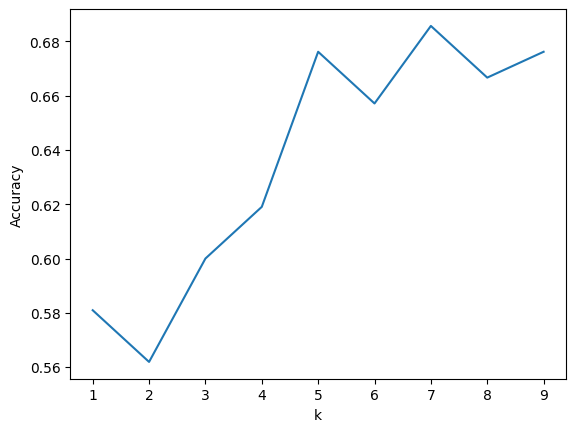

In [ ]:
knn_classification_plot(dataset, text_column, label_column, method='bow')

Best value of k: 9 with accuracy: 0.6190476190476191


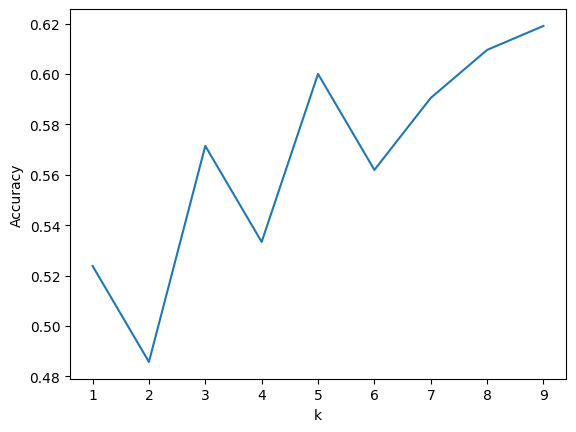

In [ ]:
knn_classification_plot(dataset, text_column, label_column, method='tfidf')

In [ ]:
import numpy as np

def knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='bow', k_range=range(1, 21), n_splits=10):
  split_accuracies = []
  for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(dataset[text_column], dataset[label_column], test_size=0.2)
    if method == 'bow':
      vectorizer = CountVectorizer(ngram_range=ngram_range)
    elif method == 'tfidf':
      vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    accuracies = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

  split_accuracies.append(accuracies)
  #Take mean accuracy across random splits
  avg_accuracies = np.mean(split_accuracies, axis=0)
  #Find best value of k vis-a-vis accuracy
  best_k = k_range[np.argmax(avg_accuracies)]
  print(f"Best value of k: {best_k} with accuracy: {max(avg_accuracies)}")
  #Plot accuracies
  plt.plot(k_range, avg_accuracies)
  plt.xlabel('k')
  plt.ylabel('Accuracy')
  plt.show()


Best value of k: 12 with accuracy: 0.638095238095238


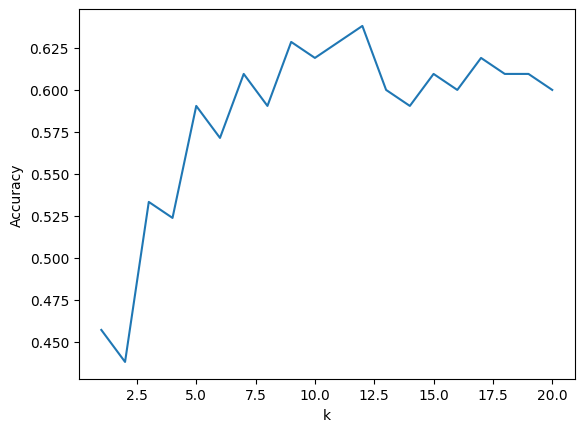

In [ ]:
ngram_range = (1,2)
min_df = 7
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='bow')

Best value of k: 4 with accuracy: 0.6


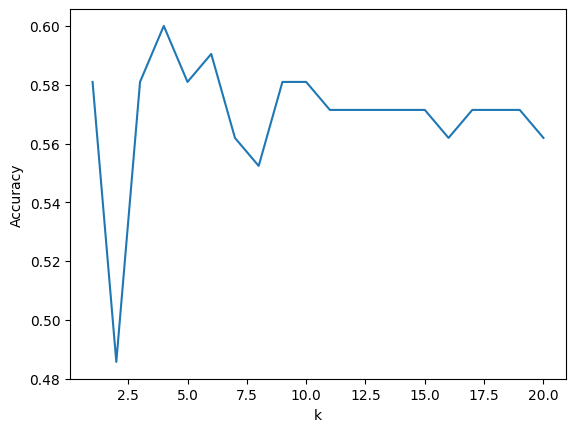

In [ ]:
ngram_range = (2,2)
min_df = 5
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='bow')

Best value of k: 1 with accuracy: 0.6095238095238096


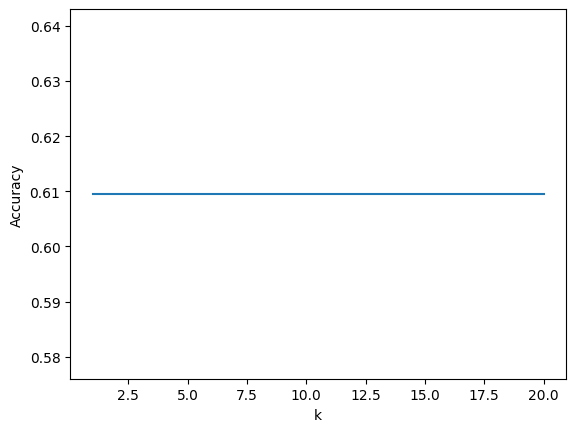

In [ ]:
ngram_range = (3,3)
min_df = 5
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='bow')

Best value of k: 7 with accuracy: 0.638095238095238


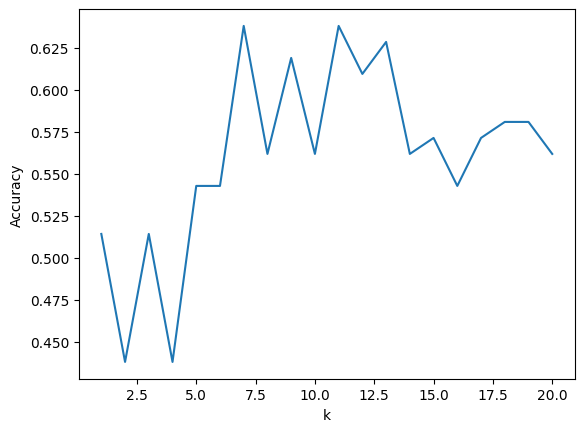

In [ ]:
ngram_range = (2,2)
min_df = 6
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

Best value of k: 16 with accuracy: 0.6190476190476191


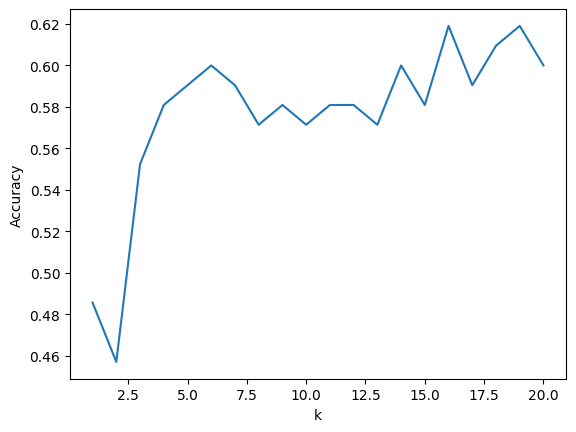

In [ ]:
ngram_range = (2,2)
min_df = 7
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

In [ ]:
ngram_range = (2,2)
min_df = 8
max_df = 0.7
knn_avg_plot(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='bow', k_range=range(1, 21), n_splits=10):
  split_f1 = []
  for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(dataset[text_column], dataset[label_column], test_size=0.2)
    if method == 'bow':
      vectorizer = CountVectorizer(ngram_range=ngram_range)
    elif method == 'tfidf':
      vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    f1_scores = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
  
  split_f1.append(f1_scores)
  #Take mean accuracy across random splits
  avg_f1 = np.mean(split_f1, axis=0)
  #Find best value of k vis-a-vis accuracy
  best_k = k_range[np.argmax(avg_f1)]
  print(f"Best value of k: {best_k} with f1: {max(avg_f1)}")
  #Plot accuracies
  plt.plot(k_range, avg_f1)
  plt.xlabel('k')
  plt.ylabel('F1')
  plt.show()


Best value of k: 11 with f1: 0.810126582278481


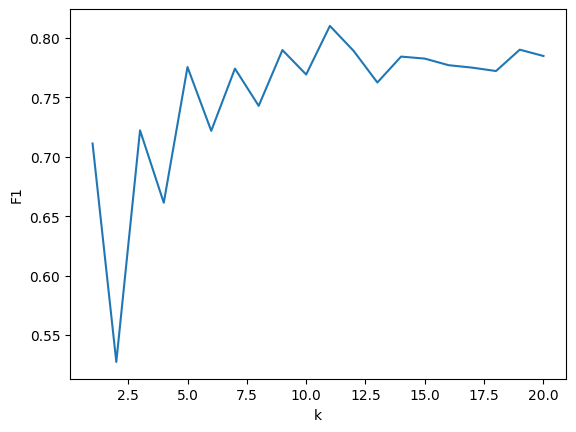

In [ ]:
ngram_range = (2,2)
min_df = 8
max_df = 0.7
knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

Best value of k: 9 with f1: 0.7894736842105262


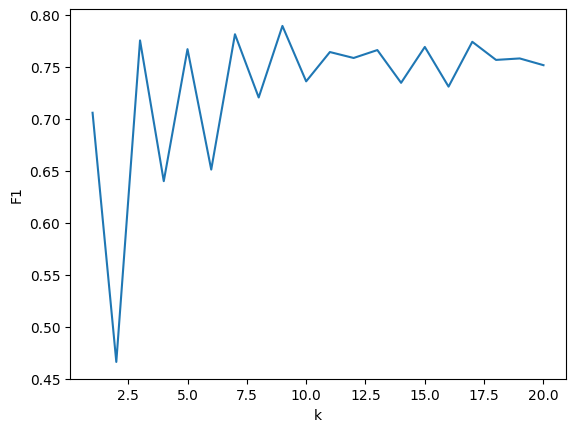

In [ ]:
ngram_range = (2,2)
min_df = 9
max_df = 0.7
knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

Best value of k: 14 with f1: 0.7172413793103449


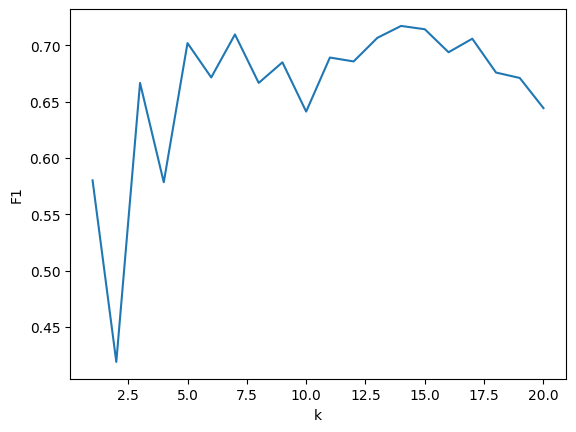

In [ ]:
ngram_range = (2,2)
min_df = 6
max_df = 0.7
knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

Best value of k: 17 with f1: 0.7354838709677419


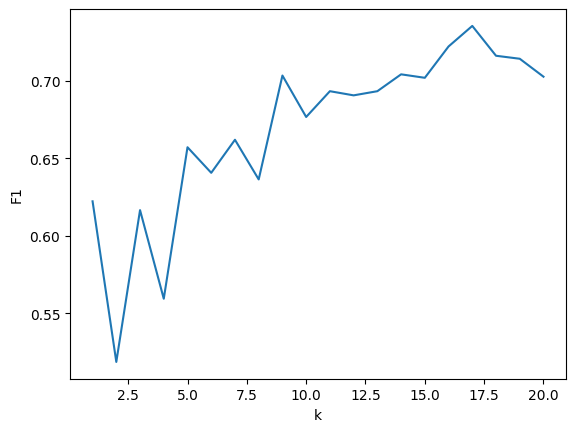

In [ ]:
ngram_range = (2,2)
min_df = 5
max_df = 0.7
knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')

Best value of k: 17 with f1: 0.7730061349693252


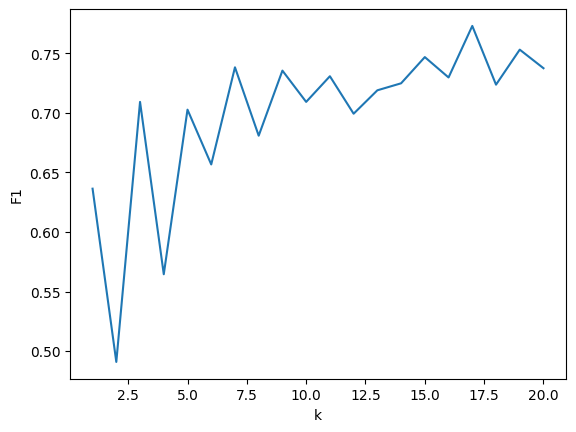

In [ ]:
ngram_range = (2,2)
min_df = 7
max_df = 0.7
knn_avg_plot_f1(dataset, text_column, label_column, ngram_range, min_df, max_df, method='tfidf')